In [8]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath('../..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# Import modules
import ddsp_textures.loss.functions
import ddsp_textures.auxiliar.filterbanks

# Import extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Load audio to filter -----------------------------------
fire_path  = ".."+"/sounds/fire_sounds/fire.wav"
water_path = ".."+"/sounds/water_sounds/water.wav"
sr     = 44100
new_sr = sr // 4 # for log_bank
fire_audio, _  = librosa.load(fire_path, sr=sr)
water_audio, _ = librosa.load(water_path, sr=sr)
# Make list of segments for fire and water --------------
frame_size     = 2**15
new_frame_size = frame_size // 4
hop_size   = 2**15
fire_segments = []
water_segments = []
for i in range(0, len(fire_audio)-frame_size, hop_size):
    fire_segments.append(fire_audio[i:i+frame_size])
for i in range(0, len(water_audio)-frame_size, hop_size):
    water_segments.append(water_audio[i:i+frame_size])
# Initialize erb_bank and log_bank for statistics loss --
N_filter_bank = 32
M_filter_bank = 20
erb_bank    = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
log_bank    = ddsp_textures.auxiliar.filterbanks.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)
import torchaudio
downsampler = torchaudio.transforms.Resample(sr, new_sr)

In [10]:
#Testing Statistics functions --------------------------------------------------

fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
water_segment = water_segments[np.random.randint(len(water_segments))]
fire_segment  = torch.tensor(fire_segment)
water_segment = torch.tensor(water_segment)
fire_stats  = ddsp_textures.loss.functions.statistics(fire_segment,  N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
water_stats = ddsp_textures.loss.functions.statistics(water_segment, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
print("Fire statistics:\n")
print("stats_1:\n", fire_stats[0])
print("stats_2:\n", fire_stats[1])
print("stats_3:\n", fire_stats[2])
print("stats_4:\n", fire_stats[3])
print("stats_5:\n", fire_stats[4])
print("Water statistics:\n")
print("stats_1:\n", water_stats[0])
print("stats_2:\n", water_stats[1])
print("stats_3:\n", water_stats[2])
print("stats_4:\n", water_stats[3])
print("stats_5:\n", water_stats[4])

Fire statistics:

stats_1:
 tensor([4.4507e-02, 2.1330e-02, 1.3921e-02, 7.9340e-03, 5.0548e-03, 2.8251e-03,
        9.6086e-04, 1.5276e-03, 2.4105e-03, 1.2357e-03, 1.1675e-03, 1.4475e-03,
        1.6439e-03, 1.1201e-03, 1.6272e-03, 1.6817e-03, 1.1964e-03, 1.4192e-03,
        1.8227e-03, 1.1449e-03, 1.0151e-03, 1.0530e-03, 1.0482e-03, 9.1108e-04,
        1.0519e-03, 1.4632e-03, 1.2353e-03, 1.5070e-03, 1.4162e-03, 1.1327e-03,
        4.6536e-04, 1.6424e-05])
stats_2:
 tensor([ 0.2953,  0.3358,  0.2539,  0.2200,  0.2957,  0.3250,  0.3808,  1.8682,
         3.8053,  2.4342,  4.4426, 10.6680, 10.3525, 12.6067, 22.8074, 20.7071,
        14.0912, 26.0653, 23.8327, 10.5415,  6.0592,  8.5815,  6.1232,  8.8720,
         5.3541, 15.8813, 11.8284, 14.6471, 11.1073,  6.1419,  3.1947, 19.3592])
stats_3:
 tensor([ 0.2560,  0.8890,  0.9646,  0.6016,  1.0301,  0.9154,  1.0723,  4.7333,
         7.2466,  5.5728,  6.7712,  8.9020,  8.6825, 10.4308, 11.4176, 12.2538,
        12.9591, 13.7711, 13.0016, 12.

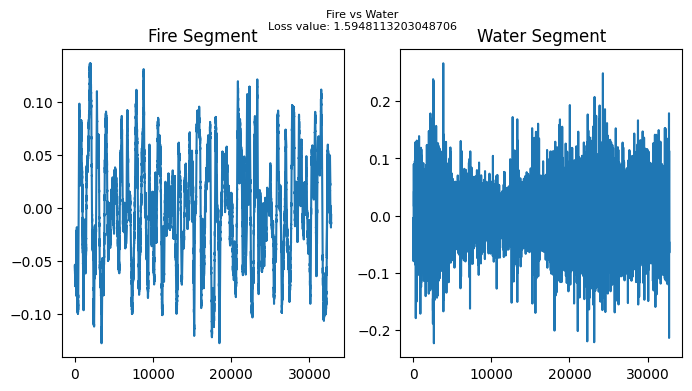

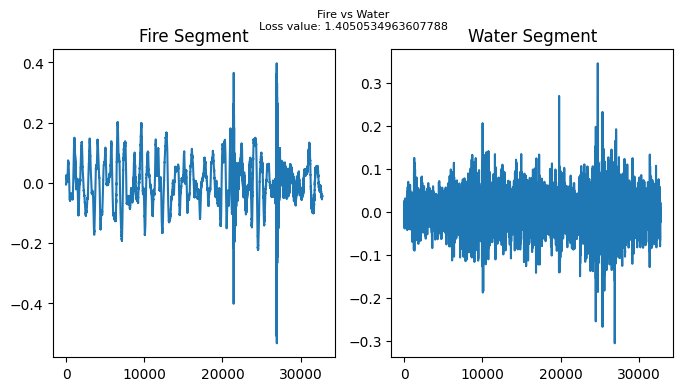

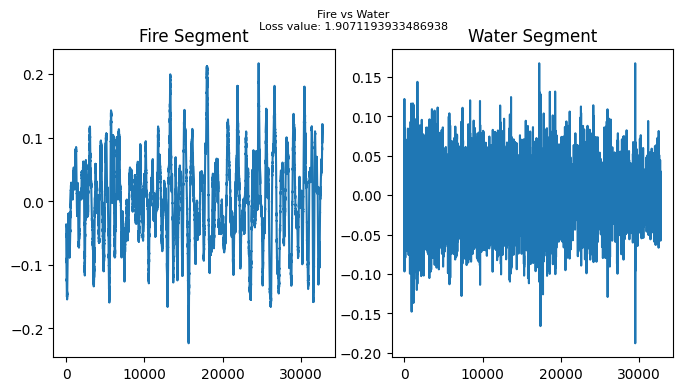

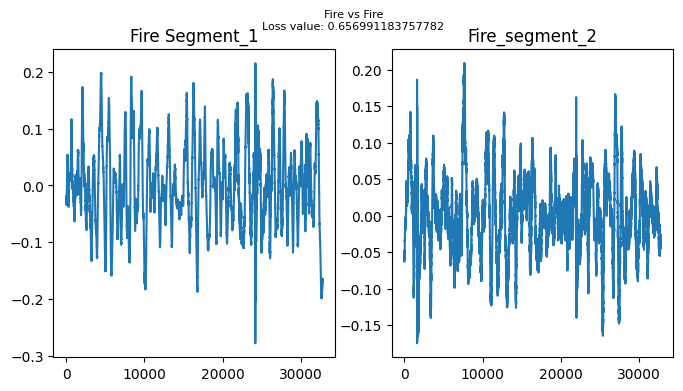

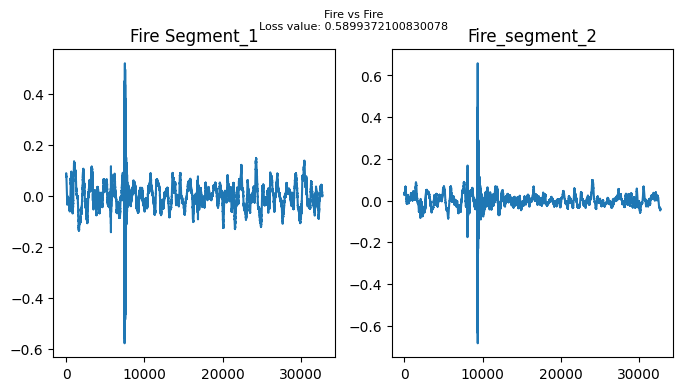

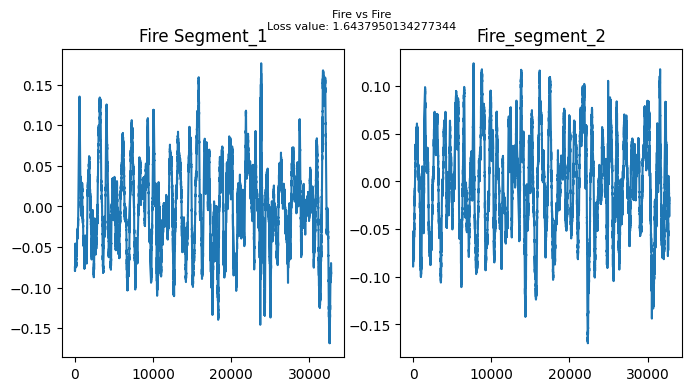

In [11]:
# Test Statistics loss function on three random pair of segments and plot them
for i in range(3):
    fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
    water_segment = water_segments[np.random.randint(len(water_segments))]
    fire_segment  = torch.tensor(fire_segment)
    #play water and fire segments
    display(Audio(fire_segment, rate=sr))
    display(Audio(water_segment, rate=sr))
    water_segment = torch.tensor(water_segment)
    loss_value = ddsp_textures.loss.functions.statistics_loss(fire_segment, water_segment, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(fire_segment)
    ax1.set_title('Fire Segment')
    ax2.plot(water_segment)
    ax2.set_title('Water Segment')
    fig.suptitle(f'Fire vs Water\nLoss value: {loss_value}', fontsize=8)
    plt.show()
# Test Statistics loss function on three random pair of fair
for i in range(3):
    fire_segment_1 = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment_2 = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment_1 = torch.tensor(fire_segment_1)
    fire_segment_2 = torch.tensor(fire_segment_2)
    #play water and fire segments
    display(Audio(fire_segment_1, rate=sr))
    display(Audio(fire_segment_2, rate=sr))
    loss_value = ddsp_textures.loss.functions.statistics_loss(fire_segment_1, fire_segment_2, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(fire_segment_1)
    ax1.set_title('Fire Segment_1')
    ax2.plot(fire_segment_2)
    ax2.set_title('Fire_segment_2')
    fig.suptitle(f'Fire vs Fire\nLoss value: {loss_value}', fontsize=8)
    plt.show()

In [12]:
#Take 16 segments and make a batch
fire_batch = []
for i in range(32):
    fire_segment = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment = torch.tensor(fire_segment)
    fire_batch.append(fire_segment)
fire_batch = torch.stack(fire_batch, dim=0)

water_batch = []
for i in range(32):
    water_segment = water_segments[np.random.randint(len(water_segments))]
    water_segment = torch.tensor(water_segment)
    water_batch.append(water_segment)
water_batch = torch.stack(water_batch, dim=0)

import time
start = time.time()
loss = ddsp_textures.loss.functions.batch_statistics_loss(fire_batch, water_batch, N_filter_bank, M_filter_bank, erb_bank, log_bank, downsampler)
end = time.time()
print("Time taken: ", end-start)
print("Batch loss value: ", loss)


Time taken:  6.307931184768677
Batch loss value:  tensor(1.5348)


In [13]:
# Load audio to filter -----------------------------------
fire_path  = ".."+"/sounds/fire_sounds/fire.wav"
water_path = ".."+"/sounds/water_sounds/water.wav"
sr     = 44100
new_sr = sr // 4 # for log_bank
fire_audio, _  = librosa.load(fire_path, sr=sr)
water_audio, _ = librosa.load(water_path, sr=sr)
# Make list of segments for fire and water --------------
frame_size     = 2**15
new_frame_size = frame_size // 4
hop_size   = 2**15
fire_segments = []
water_segments = []
for i in range(0, len(fire_audio)-frame_size, hop_size):
    fire_segments.append(fire_audio[i:i+frame_size])
for i in range(0, len(water_audio)-frame_size, hop_size):
    water_segments.append(water_audio[i:i+frame_size])
# Initialize erb_bank and log_bank for statistics loss --
N_filter_bank = 32
M_filter_bank = 20
erb_bank    = ddsp_textures.auxiliar.filterbanks.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
log_bank    = ddsp_textures.auxiliar.filterbanks.Logarithmic(new_frame_size,       new_sr, M_filter_bank, 10, new_sr // 4)
import torchaudio

import ddsp_textures.loss
downsampler = torchaudio.transforms.Resample(sr, new_sr)

# pick random segments
fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
water_segment = water_segments[np.random.randint(len(water_segments))]
fire_segment  = torch.tensor(fire_segment)
water_segment = torch.tensor(water_segment)
#play water and fire segments
display(Audio(fire_segment, rate=sr))
display(Audio(water_segment, rate=sr))
# Compute stems
from ddsp_textures.auxiliar.features import *
stems_fire  = features_envelopes_stems(fire_segment, _, erb_bank)
print("fire_shape: ", stems_fire.shape)
stems_water = features_envelopes_stems(water_segment, _, erb_bank)
print("water_shape: ", stems_water.shape)
# Compute loss
loss_value = ddsp_textures.loss.functions.statistics_loss_stems(stems_fire, stems_water, N_filter_bank, M_filter_bank, log_bank, downsampler)


fire_shape:  torch.Size([32, 32768])
water_shape:  torch.Size([32, 32768])


In [14]:
#Take 32 segments and make a batch
fire_batch = []
for i in range(32):
    fire_segment = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment = torch.tensor(fire_segment)
    fire_segment_stems = features_envelopes_stems(fire_segment, _, erb_bank)
    fire_batch.append(fire_segment_stems)
fire_batch = torch.stack(fire_batch, dim=0)

print("fire_batch_shape:  ", fire_batch.shape)

water_batch = []
for i in range(32):
    water_segment = water_segments[np.random.randint(len(water_segments))]
    water_segment = torch.tensor(water_segment)
    water_segment_stems = features_envelopes_stems(water_segment, _, erb_bank)
    water_batch.append(water_segment_stems)
water_batch = torch.stack(water_batch, dim=0)

print("water_batch_shape: ", water_batch.shape)

# compute the loss and tell me how much time it took
import time
start = time.time()
loss = ddsp_textures.loss.functions.batch_statistics_loss_stems(fire_batch, water_batch, N_filter_bank, M_filter_bank, _, log_bank, downsampler)
end = time.time()
print("Time elapsed: ", end-start)
print("Batch loss value: ", loss)

fire_batch_shape:   torch.Size([32, 32, 32768])
water_batch_shape:  torch.Size([32, 32, 32768])
Time elapsed:  5.97258448600769
Batch loss value:  tensor(1.5587)
